<img src="image/penguin-161418_1280.png" width="100" align="center">

<h1><center>How to become a Data Science Freelancer?</center></h1>

<h4>About this Notebook</h4>
This Data Science Report follows the CRISP-DM Process (Cross Industry Process for Data Mining):  

> 1. Business Understanding -> 2. Data Understanding -> 3. Data Preperation -> 4. Data Modeling -> 5. Evaluation of the Results -> 6. Deployment. 

This report consists of three parts:

1. `Data Analysis.ipynb` (this Notebook) containing the first four steps of the CRISP-DM Process   
2. `Results.ipynb`: the 5th step of the CRISP-DM Process    
3. `Medium Blog Post`: the 6th step of the CRISP-DM Process   

In this notebook, I do the Data Cleaning & Preprocessing 👉🏼 often called as the _hard & dirty work_ in Data Science 🏋🏻‍♂️!

<h1>Table of contents</h1>

<div  style="margin-top: 20px">
    <ol>
        <li><a href="#problem_understanding">Why this Analysis?</a></li>
        <ol>
            <li><a href="#motivation">Motivation</a></li>
            <li><a href="#research_questions">Research Questions in</a></li>        
        </ol>   
        <li><a href="#understanding-data">Understanding the Data</a></li>
        <ol>
            <li><a href="#reading_data">Getting the Data</a></li>          
        </ol>       
        <li><a href="#prepare_data">Data Preperation</a></li>
        <ol>
            <li><a href="#reading_data">Extracting Target Group(s)</a></li>
            <li><a href="#research_questions">Research Questions</a></li>
        </ol>
        <li><a href="#modelling_data">Data Modelling</a></li>
        <ol>
            <li><a href="#job_satisfaction">Job Satisfaction</a></li>
            <li><a href="#income">Income</a></li>
            <li><a href="#Working Hours">Working Hours</a></li>
            <li><a href="#working_style">Working Style</a></li>
            <li><a href="#coding_languages">Coding Languages</a></li>
        </ol>    
    </ol>
</div>
<br>
<hr>

### Importing Needed packages

In [291]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import imp # for reloading modules

import helper as h

# surpress Jupyter Notebook warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [292]:
imp.reload(h)

<module 'helper' from '/Users/dirkkalmbach/Library/Mobile Documents/com~apple~CloudDocs/Projekte/DSND/blog-project/helper.py'>

<h1 id="problem_understanding">Why this Analysis?</h1>

<h2 id="movivation">Motivation</h2>

I'm a student in the [Udacity Data Science Nanodegree](https://www.udacity.com/course/data-scientist-nanodegree--nd025) Program. This Jupyter Notebook is the analytic part of my first project in this Nanodegree which requires me to conduct a Data Science Blog.   
As I was always interested in Freelancing, my leading question for this analysis is: _how can I become a Data Science Freelancer?_
In particular, I answer these questions:

<h2 id="research_questions">Research Questions (... and of personal interest)</h2>

1. Are independent Data Scientists more happy with their Job than employed Data Scientists?
2. Do indpeendent Data Scientists earn more than employed Data Scientists?
3. What Coding Languages use Data Scientists? Is here any development over time?
...
4. What makes Developer in general happier? (also DevType as Dummy)
5. What skills do Data Science Freelancer have?

<h1 id="data_understanding">Data Understanding</h1>

## About the Dataset
My analysis are based on the [Stack Overflow’s annual Developer Survey](https://insights.stackoverflow.com/survey).

## Definition of Target Group(s)
The aim of this Report is to find out how Data Scientists can work independently, i.e. as Freelancer, independent contractor, or 1-person-company.
I will use the following abbreviations:
> - `Pure Data Scientists` (PDS): Data Scientists, who consider himself/herself as **only** _Data Scientists / Machine Learning Specialists_
> - `Data Scientist` (DS): Respndents who consider him/herself as *Data Scientist*, but **not only**. 
> - `Data Jobs` (DJ): 
_Data Scientists_ 👆🏻, and/or _Data/Business Anaylsts_ and/or _Data Engineers_, i.e.: Respondents who did not mark any other "



<h1 id="understanding_data">Understanding the Data</h2>

<h2 id="reading_data">Getting the Data</h2>

In [293]:
# Load survey 2019 dataset 
df = h.load_csv('data/raw data/developer_survey_2019/survey_results_public.csv.zip')
print("Dataframe sucessfully loaded.")

# Load data description
schema = h.load_csv("data/raw data/developer_survey_2019/survey_results_schema.csv")

h.df_info(df)

Dataframe sucessfully loaded.
Rows: 88883 	 Variables: 85 	 	 Size: n/a kb


<h2 id="target_groups">Extracting Target Group(s)</h2>

In [294]:
h.get_desc("Employment")

'Which of the following best describes your current employment status?'

In [295]:
h.get_cat("Employment")

['Not employed, and not looking for work',
 'Not employed, but looking for work',
 'Employed full-time',
 'Independent contractor, freelancer, or self-employed',
 nan,
 'Employed part-time',
 'Retired']

In [296]:
# Im only interested in full working people -> no parttime, students, etc.
df = df[(df["Employment"]=='Employed full-time') | (df["Employment"]=='Independent contractor, freelancer, or self-employed')]
h.df_info(df)

Rows: 72951 	 Variables: 85 	 	 Size: n/a kb


In [297]:
# TODO: überarbeiten

# Freelancing is asked 2x -> I wonder if there are some mismatches
df[ (df["Employment"]=='Independent contractor, freelancer, or self-employed') & (
     df["OrgSize"]== "Just me - I am a freelancer, sole proprietor, etc.")
  ].shape

df[df["Employment"]=='Independent contractor, freelancer, or self-employed'].shape
df[df["OrgSize"]== "Just me - I am a freelancer, sole proprietor, etc."].shape

(4233, 85)

#### How many "Pure" Data Scientists are in the dataset?

In [298]:
PDS = df[df["DevType"]=="Data scientist or machine learning specialist"]
h.df_info(PDS)

Rows: 494 	 Variables: 85 	 	 Size: n/a kb


_...and how many among them are Freelancer?_

In [299]:
# How many Freelance Pure Data Scientists?
h.df_info(
    PDS[PDS["Employment"]=="Independent contractor, freelancer, or self-employed"]
)

Rows: 25 	 Variables: 85 	 	 Size: n/a kb


Wow! 😱 Only 25 Cases! Of course, this is not enough for any valuable insights 😫

#### 👉🏻 Set Filter for Freelancer

In [300]:
# Filter for Freelancer
df = df[df["Employment"]=="Independent contractor, freelancer, or self-employed"]
print("N={} Freelancers remain in the Dataset".format(df.shape[0]))

N=8511 Freelancers remain in the Dataset


#### Group Data related Jobs

In [301]:
#TODO: Refactor with this
    #df.loc[df['column name'] condition, 'new column name'] = 'value if condition is met'

DJ=["Data scientist or machine learning specialist", "Data or business analyst", "Engineer, data"]
RS=["Academic Research","Scientist"]
DS=["Data scientist or machine learning specialist"]

def t(col, jobs, cat):
    found=False
    for job in jobs:
        if job in col:
            found=True
    if found:
        return cat
    else:
        return np.nan
            
            
# Science Jobs
df["Job_RS"]=df["DevType"].apply(lambda x: t(str(x),RS,"Something with Science"))

# Data Jobs
df["Job_DJ"]=df["DevType"].apply(lambda x: t(str(x),DJ,"Something with Data"))

# Data Scientists
df["Job_DS"]=df["DevType"].apply(lambda x: t(str(x),DS,"Data Scientist"))

# Other Jobs
df["Job_DS"]=df["DevType"].apply(lambda x: t(str(x),DS,"Data Scientist"))

# Print Results
print("Data Scientist (n): {} (NaN: {})".format( df.Job_DS.count(), df.Job_DS.isna().sum()) )
print("Something with Data: {} (NaN: {})".format( df.Job_DJ.count(),  df.Job_DJ.isna().sum()) )
print("Something with Science (n): {} (NaN: {})".format( df.Job_RS.count(), df.Job_RS.isna().sum()) ) 

Data Scientist (n): 735 (NaN: 7776)
Something with Data: 1637 (NaN: 6874)
Something with Science (n): 466 (NaN: 8045)


> 🤓 The 3 new build variables are not exclusive, i.e.: somebody who marked herself as Data Scientist, Business Analyst, and Scientist would be in all three groups!

Let's put this all in one variable TargetGroups with these categories:
- PDS
- DS
- DJ

In [302]:
# create new var 'TargetGroup'
df.loc[df['Job_DJ'] == "Something with Data", 'TargetGroup'] = 'Something with Data'
df.loc[df['Job_RS'] == "Something with Science", 'TargetGroup'] = 'Something with Science'
df.loc[df['Job_DS'] == "Data Scientist", 'TargetGroup'] = 'Data Scientist'
df["TargetGroup"].fillna(value="other Job", inplace=True)

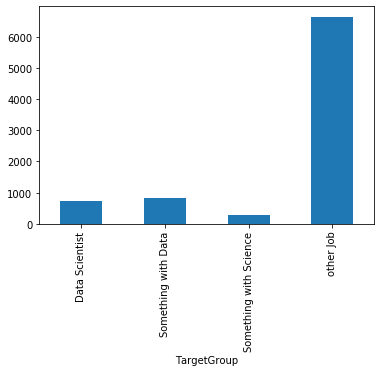

In [303]:
df.groupby("TargetGroup").count().Respondent.plot.bar()

<h2 id="job_satisfaction">Job Satisfaction</h2>

> 🤔 _How happy are Freelancer, and Data Scientists with their job?_

In [304]:
# Question in Survey 2019
h.get_desc("JobSat")

'How satisfied are you with your current job? (If you work multiple jobs, answer for the one you spend the most hours on.)'

In [305]:
# build jobsatisfaction index (1-5)

index = {'Slightly satisfied': 4, 
         'Slightly dissatisfied': 2,
         'Neither satisfied nor dissatisfied': 3,
         'Very satisfied': 5,
         'Very dissatisfied': 1,
         np.nan: np.nan
        }

df["JobSatIndex"] = df["JobSat"].apply(lambda x: index[x])

print("Avg Job Satisfaction: ", df.JobSatIndex.mean().round(2))  

Avg Job Satisfaction:  3.71


#### Job Satisfaction Difference between Freelancer and Employed

In [306]:
df.groupby('Employment') \
       .agg(n=('Employment', 'size'), Job_Satisfaction=('JobSatIndex', 'mean')).reset_index()

,Employment,n,Job_Satisfaction
0,"Independent contractor, freelancer, or self-em...",8511,3.713764


> ❗__Interesting__: no difference between Freelancer and employed

#### Job Satisfaction Difference between Data Science Jobs

In [307]:
df.groupby('TargetGroup') \
       .agg(n=('TargetGroup', 'size'), Job_Satisfaction=('JobSatIndex', 'mean')).reset_index()

,TargetGroup,n,Job_Satisfaction
0,Data Scientist,735,3.701724
1,Something with Data,832,3.755245
2,Something with Science,284,3.740909
3,other Job,6660,3.708388


> ❗only slight differences, but the direction looks interesting: Scientists are happier

<h2 id="income">Income</h2>

There are 3 questions to income:

In [308]:
h.get_desc("CompTotal")

'What is your current total compensation (salary, bonuses, and perks, before taxes and deductions), in `CurrencySymbol`? Please enter a whole number in the box below, without any punctuation. If you are paid hourly, please estimate an equivalent weekly, monthly, or yearly salary. If you prefer not to answer, please leave the box empty.'

In [309]:
h.get_desc("CompFreq")

'Is that compensation weekly, monthly, or yearly?'

In [310]:
h.get_desc("ConvertedComp")

'Salary converted to annual USD salaries using the exchange rate on 2019-02-01, assuming 12 working months and 50 working weeks.'

In [311]:
USA = df[df["Country"]=="United States"]
world = df.copy()
# Build var Salary

# 2. delete all cases with no income
USA.dropna(subset=['ConvertedComp'], inplace=True)
world.dropna(subset=['ConvertedComp'], inplace=True)

# For USA
print("Avg Salary per year (USA) \n=============================================== \n",
USA.groupby('TargetGroup') \
       .agg(n=('TargetGroup', 'size'), Salary=('ConvertedComp', 'mean')).reset_index()
)
print("\n")
# For World
print("Avg Salary per year (WORLD) \n=============================================== \n",
world.groupby('TargetGroup') \
       .agg(n=('TargetGroup', 'size'), Salary=('ConvertedComp', 'mean')).reset_index()
     )

Avg Salary per year (USA) 
               TargetGroup    n         Salary
0          Data Scientist   75  268333.493333
1     Something with Data   89  210429.303371
2  Something with Science   21  299702.380952
3               other Job  518  208688.084942


Avg Salary per year (WORLD) 
               TargetGroup     n         Salary
0          Data Scientist   364  129263.590659
1     Something with Data   455  111990.857143
2  Something with Science   127  100847.992126
3               other Job  3597  101575.716986


> ❗Data Scientists make more cash than Scientists or Data Worker

<h2 id="working_hours">Working Hours</h2>

In [312]:
h.get_desc("WorkWeekHrs")

'On average, how many hours per week do you work?'

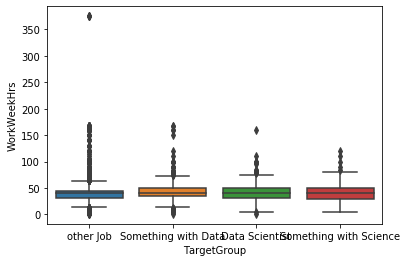

In [313]:
sns.boxplot(y="WorkWeekHrs", x="TargetGroup", data=df)

>❗Outliers! Lets say, everything more than 80h/week is unrealistic

In [314]:
# set maximum working hour per week
OUTLIER_SIZE=100

In [315]:
#TODO -> NaN in Working Hours <- Sandbox
print("Avg Working Hours per week (Freelancer)\n=========================================== \n",
df[(df.WorkWeekHrs<=OUTLIER_SIZE) & 
   (df.Employment=="Independent contractor, freelancer, or self-employed")].
      groupby('TargetGroup')
      .agg(n=('TargetGroup', 'size'), hours=('WorkWeekHrs', 'mean')).reset_index()
)

Avg Working Hours per week (Freelancer)
               TargetGroup     n      hours
0          Data Scientist   472  40.937500
1     Something with Data   583  41.262864
2  Something with Science   172  38.793605
3               other Job  4371  39.099801


In [316]:
print("Avg Working Hours per week (Employed full-time)\n=========================================== \n",
df[(df.WorkWeekHrs<=OUTLIER_SIZE) & 
   (df.Employment=="Employed full-time")].
      groupby('TargetGroup')
      .agg(n=('TargetGroup', 'size'), hours=('WorkWeekHrs', 'mean')).reset_index()
)

Avg Working Hours per week (Employed full-time)
 Empty DataFrame
Columns: [TargetGroup, n, hours]
Index: []


In [ ]:
plt.figure(figsize=(12,6))
sns.violinplot(y="WorkWeekHrs", x="TargetGroup", hue="Employment", data=df[df.WorkWeekHrs<OUTLIER_SIZE])

🤓 The Median is all the same, because the data range is between 0 and 100 hours.

<h2 id="working_style">Working Style</h2>

### Work Structure

In [ ]:
# Question in Questionaire
h.get_desc("WorkPlan")

In [ ]:
# Answer Categories in Questionaire
h.get_cat("WorkPlan")

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
#labels = ['I follow a schedule closely', 'My work somewhat aligns to schedule', 'I work on what seems most important/urgent']
labels = list(df.groupby("WorkPlan").count()["Respondent"].index)

datascientists = df[df["TargetGroup"]=="Data Scientist"].groupby("WorkPlan").count()["Respondent"]
axes[0].pie(datascientists, startangle=90, autopct='%1.1f%%')
axes[0].set_title("Data Scientists \n (n={})".format(datascientists.sum()))

dataists = df[df["TargetGroup"]=="Something with Data"].groupby("WorkPlan").count()["Respondent"]
axes[1].pie(dataists, startangle=90, autopct='%1.1f%%' )
axes[1].set_title("Dataists \n (n={})".format(dataists.sum()))

scientists = df[df["TargetGroup"]=="Something with Science"].groupby("WorkPlan").count()["Respondent"]
axes[2].pie(scientists, startangle=90, autopct='%1.1f%%' )
axes[2].set_title("Scientists \n (n={})".format(scientists.sum()))

others = df.groupby("WorkPlan").count()["Respondent"]
axes[3].pie(others, startangle=90, autopct='%1.1f%%')
axes[3].set_title("All Freelancer \n (n={})".format(others.sum()))

fig.legend(labels=labels, loc='lower center')

In [219]:
Not so many differences between Freelancer

As a comparison, here are the results for Emp

676

<h2 id="coding_languages">Coding Languages</h2>

In [138]:
# Todo: heatmap target group vs. coding languages

# Pivot Table (rows=target group, col=coding languages, values=how many code in this language)

In [139]:
schema.loc[43:51]

,Column,QuestionText
43,LanguageWorkedWith,"Which of the following programming, scripting,..."
44,LanguageDesireNextYear,"Which of the following programming, scripting,..."
45,DatabaseWorkedWith,Which of the following database environments h...
46,DatabaseDesireNextYear,Which of the following database environments h...
47,PlatformWorkedWith,Which of the following platforms have you done...
48,PlatformDesireNextYear,Which of the following platforms have you done...
49,WebFrameWorkedWith,Which of the following web frameworks have you...
50,WebFrameDesireNextYear,Which of the following web frameworks have you...
51,MiscTechWorkedWith,"Which of the following other frameworks, libra..."


In [140]:
h.get_desc("PlatformWorkedWith")

'Which of the following platforms have you done extensive development work for over the past year?   (If you both developed for the platform and want to continue to do so, please check both boxes in that row.)'

In [141]:
list(df.WorkPlan.unique())

["There's no schedule or spec; I work on what seems most important or urgent",
 'There is a schedule and/or spec (made by me or by a colleague), and I follow it very closely',
 'There is a schedule and/or spec (made by me or by a colleague), and my work somewhat aligns',
 nan]

In [142]:
if df.WorkPlan.dtype==object:
    print("d")

d


In [143]:
# Todo: create variables for every language as dummy
# balkendiagram (geordnet): Python: 80%, R: 75%, etc.
# h.get_cat("PlatformWorkedWith")
#list(df.PlatformWorkedWith.unique())

In [144]:
def get_cat(column_name, df=df):
    '''
    INPUT - schema - pandas dataframe with the schema of the developers survey
            column_name - string - the name of the column you would like to know about
    OUTPUT - 
            cat - list - categories of this variable
    '''
    if df[column_name].dtype=="object":
        return list(df[column_name].unique())
    else:
        return mean(df[column_name])